# BangleBeat

The following notebook walks through the process of making a machine learning model to improve BangleJS2 heart rate accuracy based on prior data. The ML model runs directly on the BangleJS2 watch and should serve as an easy to use pipeline for folks to make thier own Bangle more accurate for them. Further work may attempt to generalize this approach to yield an open source watch which actively learns how to improve its own heart rate measurements. 



## Data Capture

First, we should assess how good or bad the BangleJS2 performs when compared to other wearable devices. This includes the following devices:

- BangleJS2 Smart Watch
- Garmin Instinct 2X Smart Watch
- Polar H10 ECG Chest Strap

These are all supported to a sufficient degree by [Gadgetbridge](https://gadgetbridge.org/). However, in the initial phases of this project I found that the BangleJS2 does not sample heart rate data nearly as fast as the Garmin does. To give this model a fighting chance I wrote [loglog](https://github.com/lucspec/BangleApps/tree/master/apps/loglog) -- a BangleJS2 app to prioritize data collection over battery life. Initial testing yields a high enough data density to be more comprable with the other two sensors in this work.

## Analysis

With our sensors and collection mechanisms in place, we can start looking at some data.

In [53]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os

# ML Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

print("Environment Ready")

Environment Ready


With some boilerplate out of the way, let's load up our data and see what we have. The first step is to query the SQLite db to see what the tables look like. Another option is to use a tool like `sqlitebrowser` (included in the nix flake) to see which data tables might have the necessary heart rate data for this task. 

In [54]:
import sqlite3

conn = sqlite3.connect('./data/Gadgetbridge.db')

# Tables that likely have HR data
hr_tables = [
    'BANGLE_JSACTIVITY_SAMPLE',
    'GARMIN_ACTIVITY_SAMPLE',
    'GARMIN_HEART_RATE_RESTING_SAMPLE',
    'GARMIN_FIT_FILE',
    'POLAR_H10_ACTIVITY_SAMPLE'
]
for table in hr_tables:
    print("\n" + "="*80)
    print(f"TABLE: {table}")
    print("="*80)
    
    cursor = conn.cursor()
    
    # Get schema
    cursor.execute(f"PRAGMA table_info({table});")
    columns = cursor.fetchall()
    col_names = [col[1] for col in columns]
    
    print("\nColumns:")
    for col in columns:
        col_id, col_name, col_type, not_null, default, pk = col
        print(f"  {col_name:30s} {col_type:15s}")
    
    # Get count
    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]
    
    # Show sample rows with headers
    if count > 0:
        cursor.execute(f"SELECT * FROM {table} LIMIT 3;")
        samples = cursor.fetchall()
        
        print("\nSample rows (of {count:,} total rows)\n")
        print("  " + " | ".join(f"{col:14s}" for col in col_names))
        print("  " + "-" * (len(col_names) * 16))
        for row in samples:
            print("  " + " | ".join(f"{str(val):14s}" for val in row))

conn.close()


TABLE: BANGLE_JSACTIVITY_SAMPLE

Columns:
  TIMESTAMP                      INTEGER        
  DEVICE_ID                      INTEGER        
  USER_ID                        INTEGER        
  RAW_INTENSITY                  INTEGER        
  STEPS                          INTEGER        
  RAW_KIND                       INTEGER        
  HEART_RATE                     INTEGER        

Sample rows (of {count:,} total rows)

  TIMESTAMP      | DEVICE_ID      | USER_ID        | RAW_INTENSITY  | STEPS          | RAW_KIND       | HEART_RATE    
  ----------------------------------------------------------------------------------------------------------------
  1763191201     | 5              | 1              | 216            | 0              | 8              | 76            
  1763238600     | 5              | 1              | 288            | 0              | 0              | 78            
  1763239200     | 5              | 1              | 256            | 0              | 0              

In this case, the Bangle JS and Polar H10 tables were easy (1 possible table) whereas the Garmin was complicated (15 possible tables). It took a litte work, but we narrowed down the data that we need from the Gadgetbridge database! Now let's load that data into a Pandas dataframe so we can interact with easily in the future.

In [55]:
# =============================================================================
# CONFIGURATION
# =============================================================================
DB_SEARCH_PATHS = [ 
    "./data/Gadgetbridge*.db",
    "./data/Gadgetbridge*/database/Gadgetbridge",
]
CSV_SEARCH_PATHS = [
    #"./data/loglog*.csv",
    "./data/HeartRateRecord*.csv",
]

# =============================================================================
# FUNCTION: LOAD DATABASE DATA
# =============================================================================
def load_db_data(db_pattern):
    dataframes = []
    dbs = glob.glob(db_pattern)
    
    # Mapping table names to timestamp units based on Gadgetbridge schema
    # Most ACTIVITY tables are seconds, EVENT/SAMPLE tables often ms
    table_configs = {
        'GARMIN_ACTIVITY_SAMPLE': {'unit': 's'},
        'BANGLE_JSACTIVITY_SAMPLE': {'unit': 's'},
        'POLAR_H10_ACTIVITY_SAMPLE': {'unit': 's'},
        # Add others if needed
    }

    type_to_table = {
        'GARMIN_INSTINCT_2X_SOLAR': 'GARMIN_ACTIVITY_SAMPLE',
        'BANGLEJS': 'BANGLE_JSACTIVITY_SAMPLE',
        'POLAR': 'POLAR_H10_ACTIVITY_SAMPLE',
    }

    for db_path in dbs:
        try:
            conn = sqlite3.connect(db_path)
            
            # Get Devices
            devices = pd.read_sql_query("SELECT * FROM DEVICE", conn)
            
            for _, device in devices.iterrows():
                # Resolve table name
                d_type = device.get('TYPE_NAME', '')
                if not d_type: continue
                
                table = None
                if d_type in type_to_table:
                    table = type_to_table[d_type]
                elif 'GARMIN' in d_type:
                    table = 'GARMIN_ACTIVITY_SAMPLE'
                elif 'BANGLE' in d_type:
                    table = 'BANGLE_JSACTIVITY_SAMPLE'
                elif 'POLAR' in d_type:
                    table = 'POLAR_H10_ACTIVITY_SAMPLE'
                
                if not table: continue
                
                # Check if table exists
                check = conn.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'").fetchone()
                if not check: continue

                # Query Data
                query = f"SELECT TIMESTAMP, HEART_RATE FROM {table} WHERE DEVICE_ID = ? AND HEART_RATE > 0"
                df = pd.read_sql_query(query, conn, params=(device['_id'],))
                
                if not df.empty:
                    # Apply correct timestamp conversion
                    ts_unit = table_configs.get(table, {}).get('unit', 's')
                    df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit=ts_unit)
                    df['device_name'] = device['NAME']
                    df['device_type'] = d_type
                    df['source'] = 'DATABASE'
                    dataframes.append(df)
            
            conn.close()
        except Exception as e:
            print(f"Error reading {db_path}: {e}")

    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# FUNCTION: LOAD LOGLOG CSV DATA (HAS ACCELEROMETER)
# =============================================================================
def load_csv_data(csv_pattern):
    csvs = glob.glob(csv_pattern)
    dataframes = []
    
    for f in csvs:
        try:
            # Latin-1 often helps with the 'µ' symbol in units
            df = pd.read_csv(f, encoding='latin-1') 
            df.columns = df.columns.str.strip()
            
            # Rename for consistency
            rename_map = {
                'Epoch (ms)': 'TIMESTAMP',
                'BPM': 'HEART_RATE',
                'Confidence':'HRM_CONFIDENCE',
                # 'X': 'x', 'Y': 'y', 'Z': 'z', 'Total': 'total_accel'
            }
            df = df.rename(columns=rename_map)
            
            # Filter valid HR
            df = df[ (df['HEART_RATE'].notna()) & (df['HEART_RATE'] > 0) ]
            
            # Convert Timestamps (Loglog uses MS)
            df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
            df['device_name'] = 'BangleJS-CSV'
            df['device_type'] = 'BANGLEJS'
            df['source'] = 'CSV'
            
            # # Ensure accel columns exist
            # for col in ['x', 'y', 'z']:
            #     if col not in df.columns:
            #         df[col] = np.nan
            
            dataframes.append(df)
        except Exception as e:
            print(f"Skipping {f}: {e}")
            
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# EXECUTE LOAD
# =============================================================================
dbs = []

for gadgetbridge_file in DB_SEARCH_PATHS:
    df_db = load_db_data(gadgetbridge_file)
    print(f"Loaded {len(df_db):.3g} rows from {len(glob.glob(gadgetbridge_file)):3.0f} files matching \'{gadgetbridge_file}\'")
    dbs.append(df_db)

for csv_file in CSV_SEARCH_PATHS:
    df_csv = load_csv_data(csv_file)
    print(f"Loaded {len(df_csv):.3g} rows from {len(glob.glob(csv_file)):3.0f} files matching \'{csv_file}\'")
    dbs.append(df_csv)

# Combine
hr_data = pd.concat(dbs, ignore_index=True).sort_values('datetime')
print()
print(f"  Total Combined Data: {len(hr_data):.3g} rows.")

## NOTE -- THIS MODIFIES hr_data INPLACE, REDUCING THE SIZE OF THE DATA SET
hr_data.drop_duplicates(subset=None, inplace=True)
print(f"After Drop Duplicates: {len(hr_data):.3g} rows.")


Loaded 1.74e+06 rows from  10 files matching './data/Gadgetbridge*.db'
Loaded 3.99e+05 rows from   2 files matching './data/Gadgetbridge*/database/Gadgetbridge'
Loaded 7.5e+04 rows from   2 files matching './data/HeartRateRecord*.csv'

  Total Combined Data: 2.21e+06 rows.
After Drop Duplicates: 3.88e+05 rows.


In [56]:
print("\nDevices in combined data:")
devs = hr_data['device_name'].unique()
print(devs)
for device in hr_data['device_name'].unique():
    device_data = hr_data[hr_data['device_name'] == device]
    count = len(device_data)
    device_type = device_data['device_type'].iloc[0]
    date_range = device_data['datetime']
    hr_range = device_data['HEART_RATE']
    
    print(f"\n  {device} ({device_type}):")
    print(f"    Measurements: {count:,}")
    print(f"    Date range: {date_range.min().strftime('%Y-%m-%d %H:%M')} to {date_range.max().strftime('%Y-%m-%d %H:%M')}")
    print(f"    HR range: {hr_range.min():.0f} - {hr_range.max():.0f} bpm (mean: {hr_range.mean():.1f})")
    
    ## Show accelerometer data if available
    #if 'x' in device_data.columns:
    #    accel_complete = device_data[['x', 'y', 'z']].notna().all(axis=1).sum()
    #    if accel_complete > 0:
    #        print(f"    Accelerometer: {accel_complete:,} samples")


Devices in combined data:
['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A8829' 'BangleJS-CSV']

  Bangle.js db9a (BANGLEJS):
    Measurements: 24,520
    Date range: 1970-01-01 00:00 to 2025-11-28 20:30
    HR range: 49 - 184 bpm (mean: 80.4)

  Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR):
    Measurements: 166,002
    Date range: 2025-06-08 14:12 to 2025-11-26 17:44
    HR range: 38 - 176 bpm (mean: 76.2)

  Polar H10 CC3A8829 (POLARH10):
    Measurements: 122,493
    Date range: 2025-11-09 18:26 to 2025-11-27 07:09
    HR range: 58 - 174 bpm (mean: 86.6)

  BangleJS-CSV (BANGLEJS):
    Measurements: 75,046
    Date range: 2025-11-15 20:22 to 2025-11-25 23:24
    HR range: 53 - 115 bpm (mean: 79.2)


Ok, so now we have some data and it's time to do our inital condiditioning. We are most interested in how much (dis)agreement there is between the Bangle JS and our reference device. Since our devices don't have well synchronized clocks (reporting latency, etc) we can't say for certain if samples were simultaneous. An easy way to approximate this is to give an alignment tolerance. That is, how far apart samples from two devices can be and we still consider them to be simultaneous. 

In [57]:
# =============================================================================
# STEP 2: ALIGNMENT & PREPARATION
# =============================================================================
ALIGNMENT_TOLERANCE = '2s'
TRAINING_FEATURES = ['HEART_RATE', 'x', 'y', 'z']

# -------------------------------------------------------------------
# 0. REMOVE BAD TIMESTAMPS (epoch 0, null, corrupted)
# -------------------------------------------------------------------
#MIN_REAL_TIMESTAMP = pd.Timestamp("2000-01-01")
MIN_REAL_TIMESTAMP = pd.Timestamp("2025-09-01")

hr_data = hr_data.dropna(subset=["datetime"])
hr_data = hr_data[hr_data["datetime"] >= MIN_REAL_TIMESTAMP]

# 1. Split reference (GARMIN + POLAR) and bangle
#reference_df = hr_data[
#    hr_data['device_type'].str.contains('GARMIN|POLAR', case=False, na=False)
#].copy()
reference_df = hr_data[
    hr_data['device_type'].str.contains('POLAR', case=False, na=False)
].copy()
reference_df = reference_df.sort_values('datetime').dropna(subset=['HEART_RATE'])

bangle_df = hr_data[
    hr_data['device_type'].str.contains('BANGLE', case=False, na=False)
].copy()
bangle_df = bangle_df.sort_values('datetime')

print(f"Reference Samples: {len(reference_df):,}")
print(f"   Bangle Samples: {len(bangle_df):,}")


# 2. Detect and remove large gaps in reference data
MAX_GAP = pd.Timedelta("5s")

reference_df["delta"] = reference_df["datetime"].diff()
reference_df["segment"] = (reference_df["delta"] > MAX_GAP).cumsum()
reference_df = reference_df.drop(columns=["delta"])

valid_segments = []
for seg_id, seg_df in reference_df.groupby("segment"):
    if len(seg_df) < 10:
        continue
    valid_segments.append(seg_df)

reference_df = pd.concat(valid_segments, ignore_index=True).sort_values("datetime")
print(f"Reference segments after gap-removal: {reference_df['segment'].nunique()}")


# 3. Merge-asof only within valid segments
aligned_blocks = []

for seg_id, seg_ref in reference_df.groupby("segment"):
    seg_start = seg_ref["datetime"].min()
    seg_end   = seg_ref["datetime"].max()

    seg_bangle = bangle_df[
        (bangle_df["datetime"] >= seg_start) &
        (bangle_df["datetime"] <= seg_end)
    ]
    if seg_bangle.empty:
        continue

    merged = pd.merge_asof(
        seg_bangle.sort_values("datetime"),
        seg_ref[["datetime", "HEART_RATE"]].rename(columns={"HEART_RATE": "HRREF"}),
        on="datetime",
        direction="nearest",
        tolerance=pd.Timedelta(ALIGNMENT_TOLERANCE)
    )

    aligned_blocks.append(merged)

if len(aligned_blocks) == 0:
    raise RuntimeError("No aligned segments produced any matches!")

aligned_data = pd.concat(aligned_blocks, ignore_index=True)


# 4. Drop rows with no match
aligned_data = aligned_data.dropna(subset=["HRREF"])

print("\nAlignment Results:")
print(f"  Matched Rows: {len(aligned_data):,}")
print(f"  Match Rate: {len(aligned_data)/len(bangle_df):.1%}")


# 5. Final cleanup — accel + HR required
#aligned_data = aligned_data.dropna(subset=['x','y','z','HEART_RATE'])
print(f"  Rows valid for training: {len(aligned_data):,}")


Reference Samples: 122,493
   Bangle Samples: 77,737
Reference segments after gap-removal: 146

Alignment Results:
  Matched Rows: 221
  Match Rate: 0.3%
  Rows valid for training: 221


In [58]:
import random
# =============================================================================
# CONFIGURATION
# =============================================================================
# Heart rate range for normalization, semi-anonymized -- HR is a biometric
MIN_HR = 0 # Minimum heart rate for normalization
#MIN_HR = hr_data['HEART_RATE'].min() # force 0-1 to actual measurement range
MAX_HR = hr_data['HEART_RATE'].max()  

# =============================================================================
# NORMALIZE HEART RATE DATA IN DEDICATED COLUMN
# =============================================================================
if not hr_data.empty and 'HEART_RATE' in hr_data.columns:
    # Normalize to 0-1 scale
    hr_data['HR_NORMALIZED'] = (hr_data['HEART_RATE'] - MIN_HR) / (MAX_HR - MIN_HR)
    
    # Clip values to 0-1 range (in case of values outside min/max)
    #hr_data['HR_NORMALIZED'] = hr_data['HR_NORMALIZED'].clip(0, 1)
    
    print("="*80)
    print(f"✓ Added HR_NORMALIZED column")
    print("="*80)
    print(f"  Range: {hr_data['HR_NORMALIZED'].min():.3f} to {hr_data['HR_NORMALIZED'].max():.3f}")
    print(f"  Mean: {hr_data['HR_NORMALIZED'].mean():.3f}")
    
    # Show any clipped values
    clipped_low = (hr_data['HEART_RATE'] < MIN_HR).sum()
    clipped_high = (hr_data['HEART_RATE'] > MAX_HR).sum()
    if clipped_low > 0:
        print(f"  ⚠ Clipped {clipped_low} values below {MIN_HR} bpm to 0.0")
    if clipped_high > 0:
        print(f"  ⚠ Clipped {clipped_high} values above {MAX_HR} bpm to 1.0")

NORMALIZED = True


✓ Added HR_NORMALIZED column
  Range: 0.261 to 1.000
  Mean: 0.462


First, a quick look at what the data looks like. Raw distribution gives a good feel for how "big" of a data set we have for each device. The normalized density shows how (dis)similar our sets are.

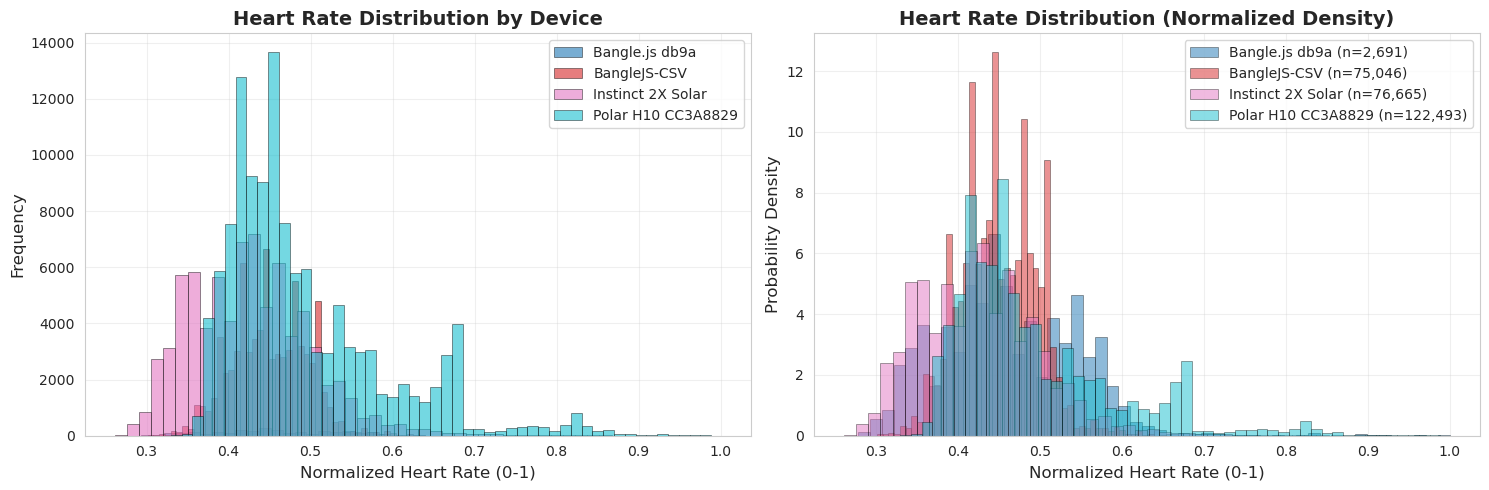

In [59]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
BINS = 50
FIGSIZE = (15, 5)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    xlabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Left: Individual histograms (stacked)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        axes[0].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density plots (normalized for comparison)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        n_samples = len(device_data)
        axes[1].hist(device_data, bins=BINS, alpha=0.5, 
                    label=f'{device} (n={n_samples:,})', 
                    color=color, edgecolor='black', linewidth=0.5,
                    density=True)
    
    axes[1].set_title('Heart Rate Distribution (Normalized Density)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(xlabel, fontsize=12)
    axes[1].set_ylabel('Probability Density', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

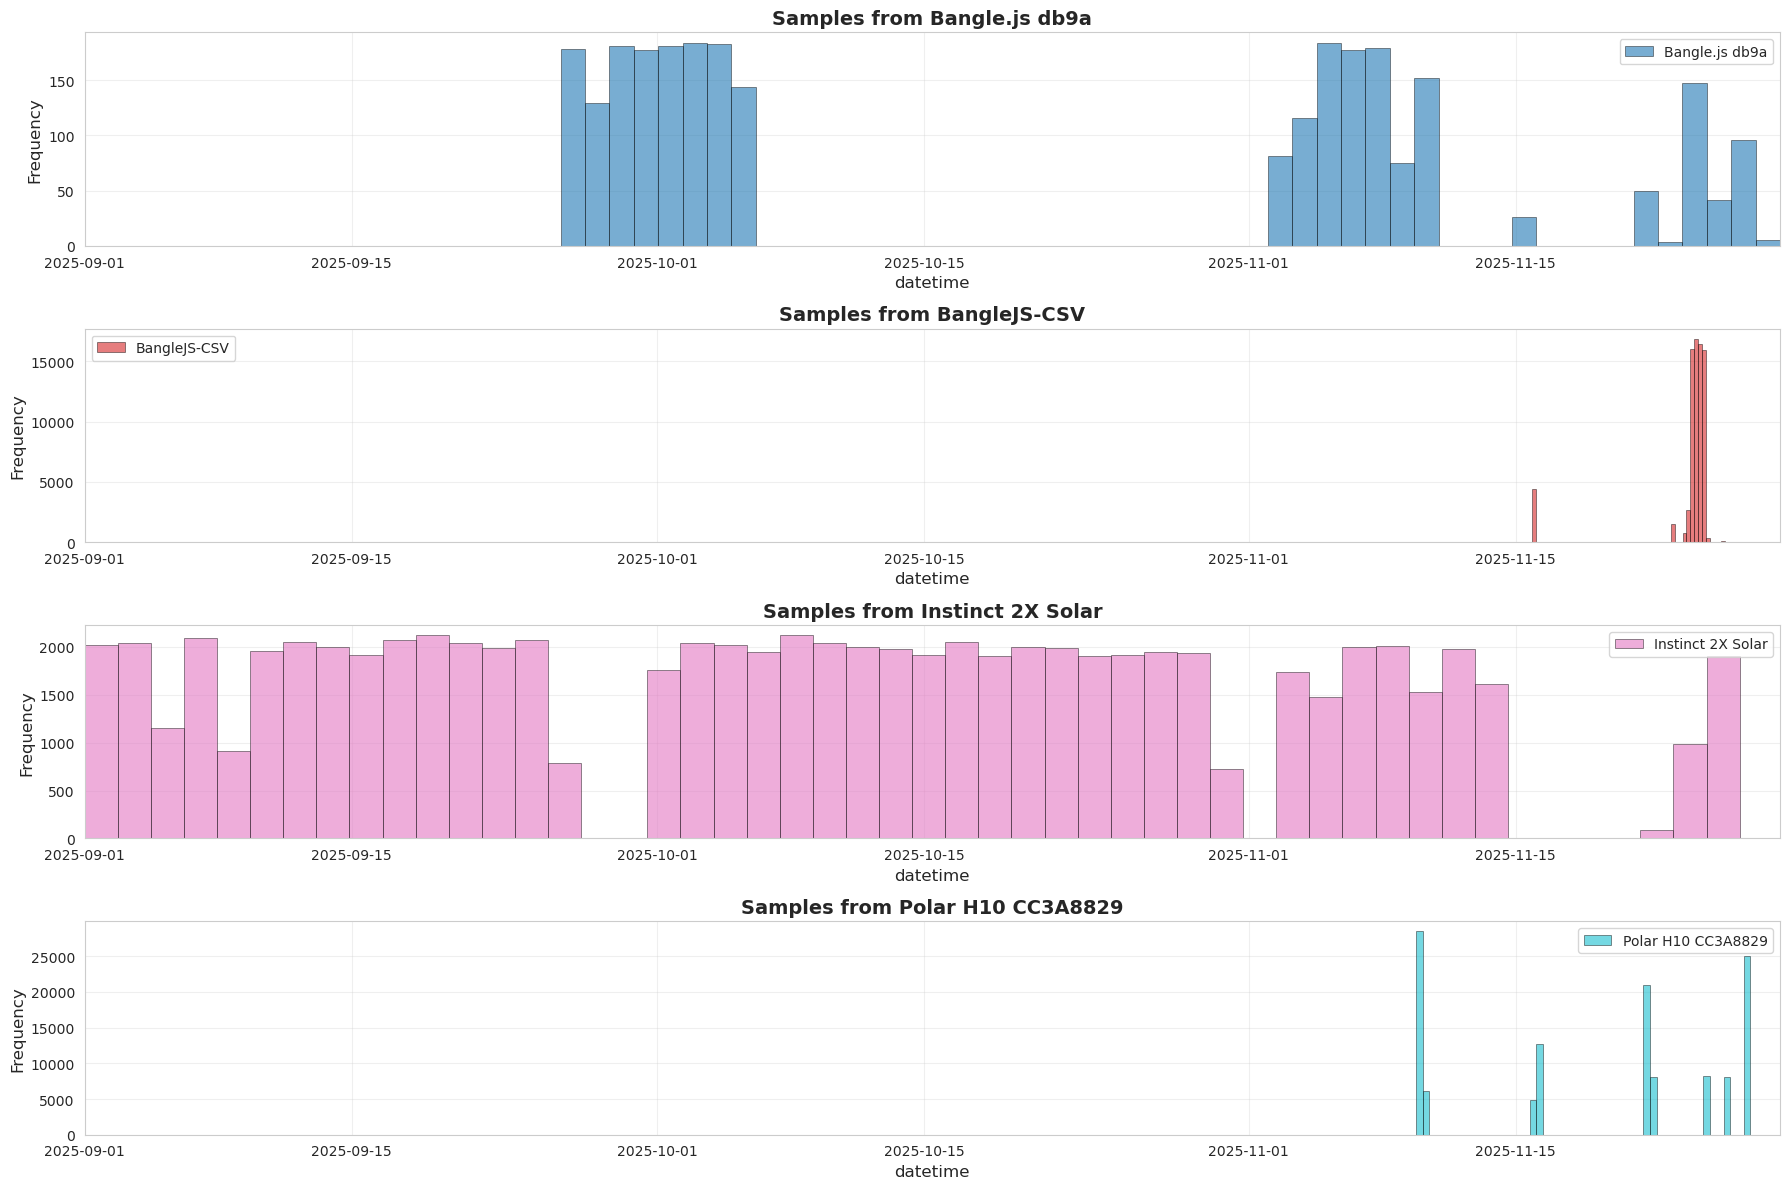

In [60]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
BINS = 50
FIGSIZE = (18, 12)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    devices = sorted(hr_data['device_name'].unique())
    ndevices = len(devices)
    colors = plt.cm.tab10(np.linspace(0, 1, ndevices))
    fig, axes = plt.subplots(ndevices, 1, figsize=FIGSIZE)
    
    # Select column
    dt_column = 'datetime'
    xlabel = 'datetime'
    xmin = hr_data['datetime'].min()    
    xmax = hr_data['datetime'].max()

    # Left: Individual histograms (stacked)
    for device, color, n in zip(devices, colors, range(0,ndevices)):
        device_data = hr_data[hr_data['device_name'] == device][dt_column]
        axes[n].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
        axes[n].set_title(f'Samples from {device}', fontsize=14, fontweight='bold')
        axes[n].set_xlabel(xlabel, fontsize=12)
        axes[n].set_xlim([xmin,xmax])
        axes[n].set_ylabel('Frequency', fontsize=12)
        axes[n].legend()
        axes[n].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

CORRELATION ANALYSIS (vs Polar H10 CC3A8829)

Instinct 2X Solar:
  Paired samples: 707
  Correlation (R): 0.666
  R²: 0.443
  MAE: 0.04 bpm
  RMSE: 0.05 bpm
  Mean difference: -0.02 bpm

Bangle.js db9a:
  Paired samples: 165
  Correlation (R): 0.445
  R²: 0.198
  MAE: 0.07 bpm
  RMSE: 0.10 bpm
  Mean difference: -0.01 bpm

BangleJS-CSV:
  Paired samples: 60
  Correlation (R): 0.284
  R²: 0.081
  MAE: 0.07 bpm
  RMSE: 0.07 bpm
  Mean difference: 0.07 bpm


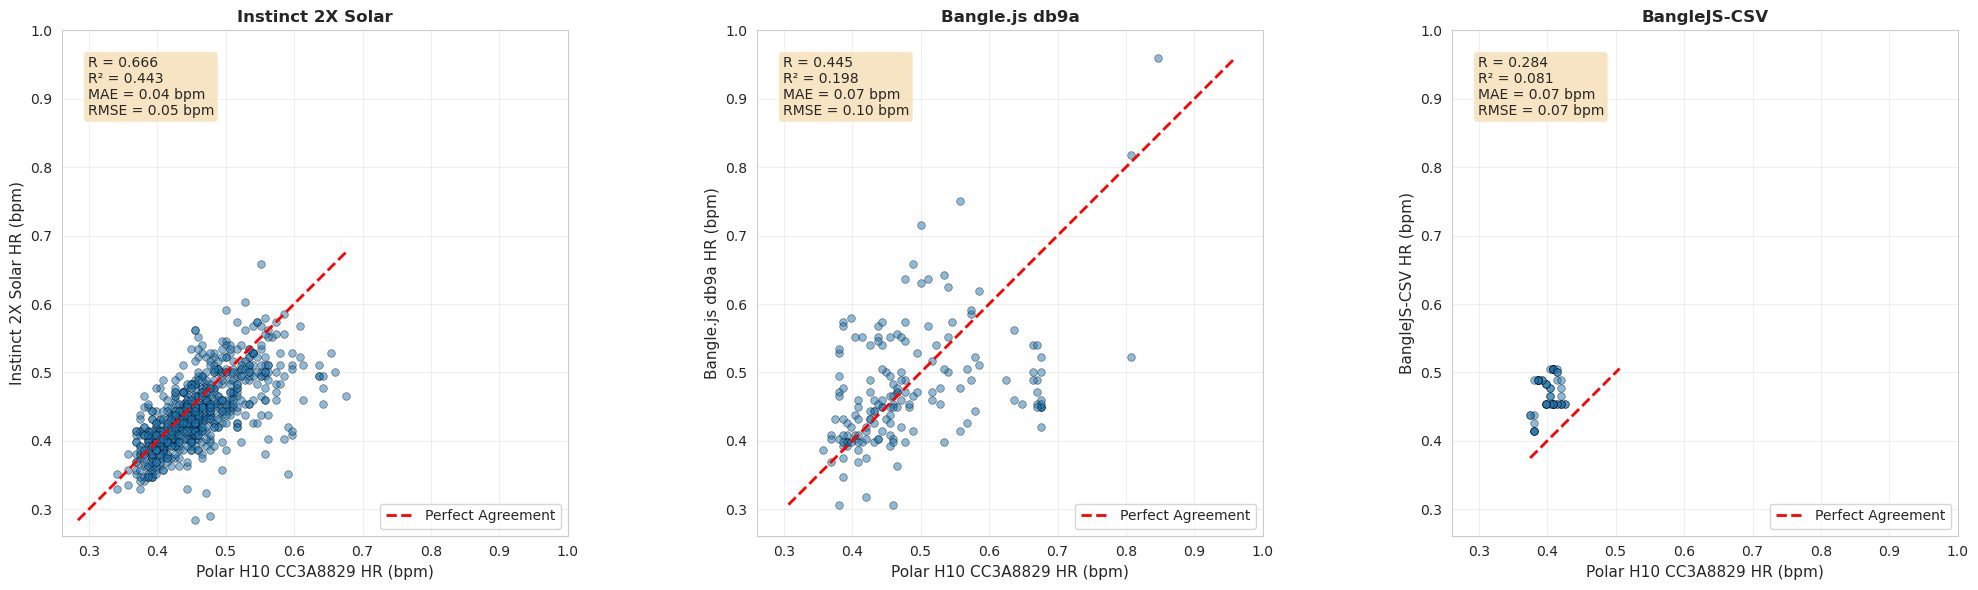

In [61]:
#!/usr/bin/env python3
"""
Device HR Correlation Scatter Plots
Shows how well each device correlates with reference device
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
REFERENCE_DEVICE = 'Polar H10 CC3A8829'  # Reference device (gold standard)
TOLERANCE_SECONDS = 60  # Max time difference for matching measurements
FIGSIZE_PER_DEVICE = 7
PLOT_RANGE = [hr_data['HR_NORMALIZED'].min(),hr_data['HR_NORMALIZED'].max()]

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    # Try to find reference device
    polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
    
    if polar_data.empty:
        polar_matches = hr_data[hr_data['device_name'].str.contains('Polar', case=False, na=False)]
        if not polar_matches.empty:
            REFERENCE_DEVICE = polar_matches['device_name'].iloc[0]
            polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
            print(f"Using reference device: {REFERENCE_DEVICE}")
    
    if polar_data.empty:
        print(f"Error: Reference device not found in data")
        print(f"Available devices: {list(hr_data['device_name'].unique())}")
    else:
        polar_data = polar_data[['datetime', 'HR_NORMALIZED']].copy()
        polar_data.columns = ['datetime', 'polar_hr']
        
        other_devices = [d for d in hr_data['device_name'].unique() if d != REFERENCE_DEVICE]
        
        if not other_devices:
            print("Error: Need at least one other device for comparison")
        else:
            n_devices = len(other_devices)
            fig, axes = plt.subplots(1, n_devices, figsize=(FIGSIZE_PER_DEVICE*n_devices, 6))
            
            if n_devices == 1:
                axes = [axes]
            
            print("="*80)
            print(f"CORRELATION ANALYSIS (vs {REFERENCE_DEVICE})")
            print("="*80)
            
            for idx, device in enumerate(other_devices):
                device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HR_NORMALIZED']].copy()
                device_data.columns = ['datetime', 'device_hr']
                
                # Merge on nearest timestamps
                merged = pd.merge_asof(
                    device_data.sort_values('datetime'),
                    polar_data.sort_values('datetime'),
                    on='datetime',
                    direction='nearest',
                    tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
                ).dropna()
                
                if not merged.empty:
                    axes[idx].scatter(merged['polar_hr'], merged['device_hr'], 
                                     alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
                    
                    # Plot perfect agreement line
                    min_val = min(merged['polar_hr'].min(), merged['device_hr'].min())
                    max_val = max(merged['polar_hr'].max(), merged['device_hr'].max())
                    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                                  'r--', linewidth=2, label='Perfect Agreement')
                    
                    # Calculate statistics
                    correlation = merged['polar_hr'].corr(merged['device_hr'])
                    mae = np.abs(merged['device_hr'] - merged['polar_hr']).mean()
                    rmse = np.sqrt(((merged['device_hr'] - merged['polar_hr']) ** 2).mean())
                    
                    # Display stats on plot
                    stats_text = f'R = {correlation:.3f}\nR² = {correlation**2:.3f}\nMAE = {mae:.2f} bpm\nRMSE = {rmse:.2f} bpm'
                    axes[idx].text(0.05, 0.95, stats_text,
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                  fontsize=10)
                    
                    axes[idx].set_xlabel(f'{REFERENCE_DEVICE} HR (bpm)', fontsize=11)
                    axes[idx].set_ylabel(f'{device} HR (bpm)', fontsize=11)
                    axes[idx].set_xlim(PLOT_RANGE)
                    axes[idx].set_ylim(PLOT_RANGE)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(True, alpha=0.3)
                    axes[idx].set_aspect('equal', adjustable='box')
                    
                    # Print statistics
                    print(f"\n{device}:")
                    print(f"  Paired samples: {len(merged):,}")
                    print(f"  Correlation (R): {correlation:.3f}")
                    print(f"  R²: {correlation**2:.3f}")
                    print(f"  MAE: {mae:.2f} bpm")
                    print(f"  RMSE: {rmse:.2f} bpm")
                    print(f"  Mean difference: {(merged['device_hr'] - merged['polar_hr']).mean():.2f} bpm")
                else:
                    axes[idx].text(0.5, 0.5, f'No overlapping data\nwith {REFERENCE_DEVICE}',
                                  ha='center', va='center', transform=axes[idx].transAxes,
                                  fontsize=12)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    print(f"\n{device}: No overlapping data within {TOLERANCE_SECONDS}s")
            
            plt.tight_layout()
            plt.show()

In [62]:
# %% [markdown]
# # HRM Calibration Model for Bangle.js 2
# Train ML model to improve Bangle.js 2 HRM using Garmin/Polar reference data

# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import os

ALIGNMENT_TOLERANCE = '3s'  # adjust if needed

sns.set_style('whitegrid')

# ## Step 1: Split by Device Type

bangle_df = hr_data[hr_data['device_type'].str.contains('BANGLE', case=False, na=False)].copy()
reference_df = hr_data[hr_data['device_type'].str.contains('GARMIN|POLAR', case=False, na=False)].copy()

print(f"Bangle.js data: {len(bangle_df):,} measurements")
print(f"Reference data: {len(reference_df):,} measurements")
print(f"  - Garmin: {len(reference_df[reference_df['device_type'].str.contains('GARMIN', case=False)])}")
print(f"  - Polar: {len(reference_df[reference_df['device_type'].str.contains('POLAR', case=False)])}")

# %% [markdown]
# ## Step 2: Time Alignment Using merge_asof

# Sort both dataframes
bangle_df = bangle_df.sort_values('datetime')
reference_df = reference_df.sort_values('datetime')

# Merge using nearest datetime, handling duplicates safely
aligned_data = pd.merge_asof(
    bangle_df,
    reference_df[['datetime','HEART_RATE']].rename(columns={'HEART_RATE':'HRREF'}),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta(ALIGNMENT_TOLERANCE)
)

# Remove duplicate reference timestamps (required for interpolation)
reference_df = reference_df.drop_duplicates(subset='datetime')

# # Set reference datetime as index for interpolation
# reference_interp = reference_df.set_index('datetime')['HEART_RATE'].sort_index().reindex(
#     pd.date_range(reference_df['datetime'].min(), reference_df['datetime'].max(), freq='0.1s')
# ).interpolate('linear')

# # Map interpolated reference HR to Bangle timestamps
# bangle_df['HRREF'] = bangle_df['datetime'].map(reference_interp)

# # Drop any rows where interpolation failed
# aligned_data = bangle_df.dropna(subset=['HRREF']).copy()

aligned_data = aligned_data.dropna(subset=['HRREF'])
print(f"✓ Aligned {len(aligned_data):,} data points with tolerance={ALIGNMENT_TOLERANCE}")


Bangle.js data: 77,737 measurements
Reference data: 199,158 measurements
  - Garmin: 76665
  - Polar: 122493
✓ Aligned 1,523 data points with tolerance=3s


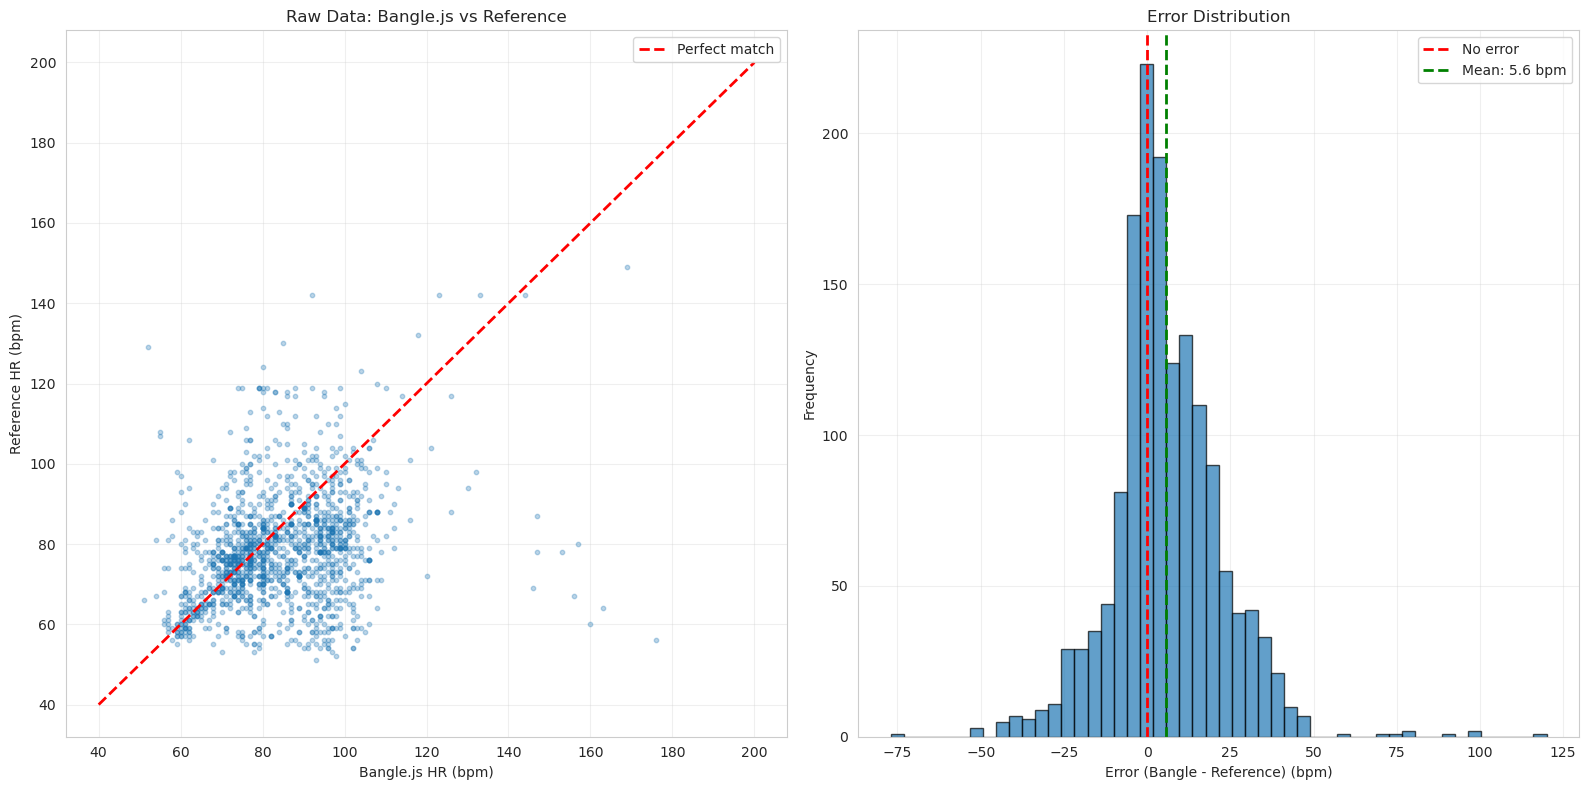

In [63]:
# %% Visualize alignment quality
fig, axes = plt.subplots(1,2,figsize=(16,8))

# Scatter
axes[0].scatter(aligned_data['HEART_RATE'], aligned_data['HRREF'], alpha=0.3, s=10)
axes[0].plot([40,200],[40,200],'r--', lw=2, label='Perfect match')
axes[0].set_xlabel('Bangle.js HR (bpm)')
axes[0].set_ylabel('Reference HR (bpm)')
axes[0].set_title('Raw Data: Bangle.js vs Reference')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error histogram
error = aligned_data['HEART_RATE'] - aligned_data['HRREF']
axes[1].hist(error, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0,color='r', linestyle='--', lw=2, label='No error')
axes[1].axvline(error.mean(),color='g', linestyle='--', lw=2, label=f'Mean: {error.mean():.1f} bpm')
axes[1].set_xlabel('Error (Bangle - Reference) (bpm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Baseline MAE (before calibration): 12.62 bpm

DATA SPLIT (before feature engineering)
Train:  1,218 samples ( 80.0%)
Test:     305 samples ( 20.0%)

FEATURE ENGINEERING (no leakage)

Processing TRAINING data:
   Detected 1162 segments
   Segment sizes - Largest: 27, Mean: 1, Smallest: 1
   ✓ Final result: 13 rows from 2 segments

Processing TEST data:
   Detected 85 segments
   Segment sizes - Largest: 68, Mean: 4, Smallest: 1
   ✓ Final result: 144 rows from 4 segments

DATA RETENTION CHECK
Train:     13 /  1,218 (1.1% retained)
Test:     144 /    305 (47.2% retained)

FEATURE ANALYSIS (20 features created)

Top 15 features by absolute correlation:
 1. hr_rolling_mean_20        0.6603
 2. hr_lag_1                  0.6454
 3. hr_lag_20                 0.6207
 4. hr_change_5               0.4763
 5. hr_rolling_max_5          0.4643
 6. hr_rolling_max_20         0.4299
 7. hr_rolling_min_20         0.4299
 8. hr_rolling_min_10         0.4299
 9. hr_rolling_std_20         0.4265
10. hr_ch

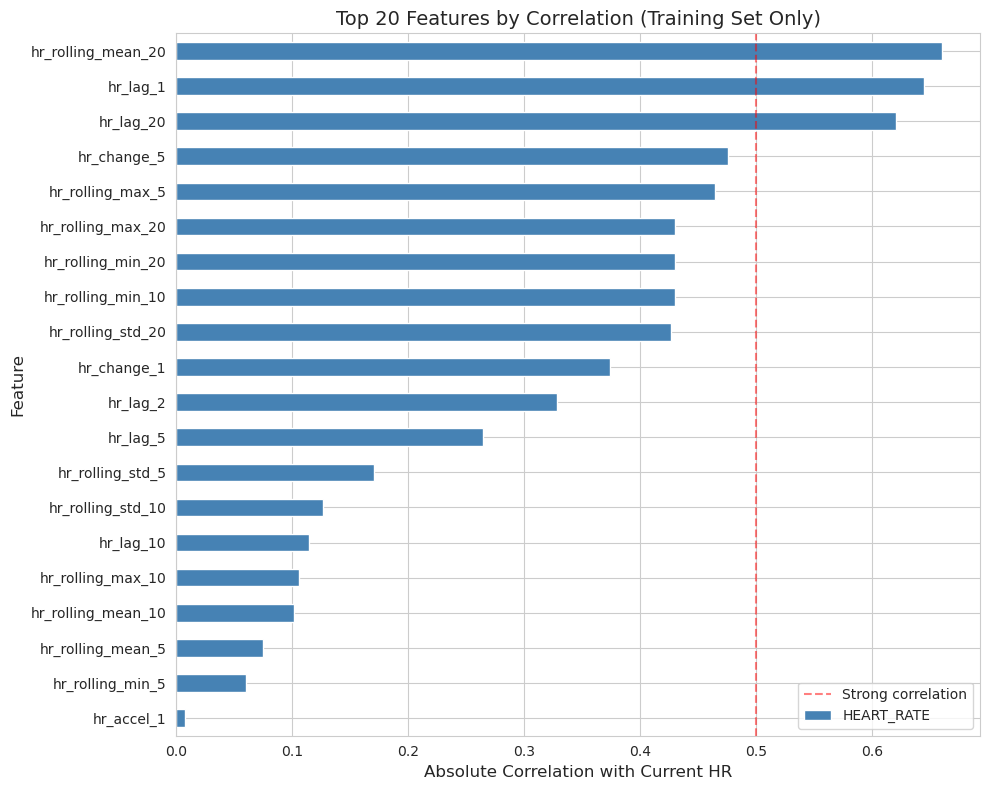


✓ Selected 16 features for modeling

✓ Feature matrices prepared:
  Train: (13, 16)
  Test:  (144, 16)


In [90]:
# %% [markdown]
# ## Step 2: Define Temporal Feature Engineering (No Leakage)
VERBOSE=False
def create_temporal_features(df, lookback_steps=[1, 2, 5, 10, 20], gap_threshold_minutes=1):
    """
    Create features that capture HR dynamics using ONLY past information.
    Handles gaps in time series by detecting continuity breaks.
    
    CRITICAL: Must be called separately on train/test splits to prevent leakage.
    """
    df = df.copy()
    
    # Ensure datetime sorted
    if 'datetime' in df.columns:
        df = df.sort_values('datetime').reset_index(drop=True)
    else:
        df = df.sort_index().reset_index(drop=True)
    
    # Detect gaps in recording (if datetime column exists)
    if 'datetime' in df.columns:
        time_diffs = df['datetime'].diff()
        gap_threshold = pd.Timedelta(minutes=gap_threshold_minutes)
        segment_breaks = time_diffs > gap_threshold
        df['segment_id'] = segment_breaks.cumsum()
    else:
        # No datetime - treat entire dataset as one segment
        df['segment_id'] = 0
    
    num_segments = df['segment_id'].nunique()
    segment_sizes = df.groupby('segment_id').size().sort_values(ascending=False)
    print(f"   Detected {num_segments} segments")
    print(f"   Segment sizes - Largest: {segment_sizes.iloc[0]}, Mean: {segment_sizes.mean():.0f}, Smallest: {segment_sizes.iloc[-1]}")
    
    # Process each segment independently to prevent cross-segment leakage
    features_list = []
    min_segment_size = 20  # Need enough history for 30-step lookback
    
    for segment_id in df['segment_id'].unique():
        segment = df[df['segment_id'] == segment_id].copy()
        
        if len(segment) < min_segment_size:
            if VERBOSE:
                print(f"   ⚠ Skipping segment {segment_id} (only {len(segment)} samples < {min_segment_size} required)")
            continue
        
        if VERBOSE:
            print(f"   Processing segment {segment_id}: {len(segment)} samples")
        
        # === LAGGED VALUES (past HR readings) ===
        for step in lookback_steps:
            segment[f'hr_lag_{step}'] = segment['HEART_RATE'].shift(step)
        
        # === FIRST-ORDER CHANGES (velocity) ===
        segment['hr_change_1'] = segment['HEART_RATE'].shift(1) - segment['HEART_RATE'].shift(2)
        segment['hr_change_5'] = segment['HEART_RATE'].shift(1) - segment['HEART_RATE'].shift(6)
        
        # === SECOND-ORDER CHANGES (acceleration) ===
        segment['hr_accel_1'] = segment['hr_change_1'].shift(1) - segment['hr_change_1'].shift(2)
        
        # === ROLLING STATISTICS (context windows) ===
        for window in [5, 10, 20]:
            # CRITICAL: shift(1) ensures we only use past data
            past_hr = segment['HEART_RATE'].shift(1)
            
            # Use min_periods=2 for std to avoid NaN on single values
            segment[f'hr_rolling_mean_{window}'] = past_hr.rolling(window=window, min_periods=1).mean()
            segment[f'hr_rolling_std_{window}'] = past_hr.rolling(window=window, min_periods=2).std().fillna(0)
            segment[f'hr_rolling_min_{window}'] = past_hr.rolling(window=window, min_periods=1).min()
            segment[f'hr_rolling_max_{window}'] = past_hr.rolling(window=window, min_periods=1).max()
        
        # Get all feature columns
        feature_cols = [col for col in segment.columns if col.startswith((
            'hr_lag_', 'hr_change_', 'hr_accel_', 'hr_rolling_'
        ))]
        
        # Check for required target columns
        required_cols = feature_cols.copy()
        if 'HRREF' in segment.columns:
            required_cols.append('HRREF')
        if 'HEART_RATE' in segment.columns:
            required_cols.append('HEART_RATE')
        
        # Drop rows with NaN in required columns
        before_drop = len(segment)
        segment = segment.dropna(subset=required_cols)
        after_drop = len(segment)
        
        if VERBOSE:
            print(f"      After dropna: {after_drop} samples remain (dropped {before_drop - after_drop})")
        
        if len(segment) > 0:
            features_list.append(segment)
    
    if len(features_list) == 0:
        raise ValueError("ERROR: No segments had sufficient data after feature creation!")
    
    result = pd.concat(features_list, ignore_index=True)
    print(f"   ✓ Final result: {len(result):,} rows from {len(features_list)} segments")
    
    return result


# %% [markdown]
# ## Step 3: Temporal Train/Test Split (80/20)

# Calculate baseline MAE
raw_mae = mean_absolute_error(aligned_data['HRREF'], aligned_data['HEART_RATE'])
print(f"Baseline MAE (before calibration): {raw_mae:.2f} bpm\n")

# Sort by time
aligned_data = aligned_data.sort_values('datetime').reset_index(drop=True)

# CRITICAL: Split BEFORE feature engineering to prevent leakage
n = len(aligned_data)
train_end = int(n * 0.8)

train_raw = aligned_data.iloc[:train_end].copy()
test_raw = aligned_data.iloc[train_end:].copy()

print(f"{'='*60}")
print("DATA SPLIT (before feature engineering)")
print(f"{'='*60}")
print(f"Train: {len(train_raw):>6,} samples ({len(train_raw)/n*100:>5.1f}%)")
print(f"Test:  {len(test_raw):>6,} samples ({len(test_raw)/n*100:>5.1f}%)")


# %% [markdown]
# ## Step 4: Apply Feature Engineering to Each Split Independently

print(f"\n{'='*60}")
print("FEATURE ENGINEERING (no leakage)")
print(f"{'='*60}")

print("\nProcessing TRAINING data:")
train_data = create_temporal_features(train_raw)

print("\nProcessing TEST data:")
test_data = create_temporal_features(test_raw)

# Verify no severe data loss
print(f"\n{'='*60}")
print("DATA RETENTION CHECK")
print(f"{'='*60}")
print(f"Train: {len(train_data):>6,} / {len(train_raw):>6,} ({len(train_data)/len(train_raw)*100:.1f}% retained)")
print(f"Test:  {len(test_data):>6,} / {len(test_raw):>6,} ({len(test_data)/len(test_raw)*100:.1f}% retained)")


# %% [markdown]
# ## Step 5: Analyze Feature Importance (Training Data Only)

# Identify all temporal features
feature_cols = [col for col in train_data.columns if col.startswith((
    'hr_lag_', 'hr_change_', 'hr_accel_', 'hr_rolling_'
))]

print(f"\n{'='*60}")
print(f"FEATURE ANALYSIS ({len(feature_cols)} features created)")
print(f"{'='*60}")

# Correlation analysis on TRAINING data only (no leakage)
correlations = train_data[feature_cols + ['HEART_RATE']].corr()['HEART_RATE'].drop('HEART_RATE').abs()
correlations = correlations.sort_values(ascending=False)

print("\nTop 15 features by absolute correlation:")
for i, (feat, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"{i:>2}. {feat:<25s} {corr:.4f}")

# Visualize
plt.figure(figsize=(10, 8))
correlations.head(20).sort_values().plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Current HR', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Correlation (Training Set Only)', fontsize=14)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Strong correlation')
plt.legend()
plt.tight_layout()
plt.show()

# Feature selection: Keep top N features + always include current HR
top_n_features = 15
selected_features = correlations.head(top_n_features).index.tolist()
selected_features.append('HEART_RATE')  # Always include raw HR

print(f"\n✓ Selected {len(selected_features)} features for modeling")


# %% [markdown]
# ## Step 6: Prepare Feature Matrices

X_train = train_data[selected_features].copy()
y_train = train_data['HRREF'].copy()

X_test = test_data[selected_features].copy()
y_test = test_data['HRREF'].copy()

# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Feature matrices prepared:")
print(f"  Train: {X_train_scaled.shape}")
print(f"  Test:  {X_test_scaled.shape}")




MODEL TRAINING & EVALUATION

[1/7] Ridge Regression
      Test MAE: 8.97 bpm | RMSE: 10.53 | R²: -1.096

[2/7] Random Forest
      Test MAE: 8.58 bpm | RMSE: 10.29 | R²: -1.004

[3/7] Gradient Boosting
      Test MAE: 9.38 bpm | RMSE: 10.92 | R²: -1.256

[4/7] XGBoost - SKIPPED (not installed)

[NN Debug] Target (HRREF) stats:
  Mean: 71.54, Std: 1.51
  Min: 70.00, Max: 76.00
  Normalized - Mean: 0.00, Std: 1.00


/nix/store/k6ma8dzn8vdj70i7b0njy65gl9ig5028-python3-3.12.12-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[5/7] Simple Neural Network (Embeddable)
      Architecture: 16→8→1 neurons + BatchNorm
      Parameters: 481 (~1.9 KB)
      Trained: 31 epochs
      Final train loss: 1.3042
      Final val loss: 0.1145
      Test MAE: 10.08 bpm | RMSE: 12.20 | R²: -1.815


/nix/store/k6ma8dzn8vdj70i7b0njy65gl9ig5028-python3-3.12.12-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[6/7] Medium Neural Network
      Architecture: 32→16→8→1 neurons + BatchNorm + Dropout
      Parameters: 1,409 (~5.5 KB)
      Trained: 30 epochs
      Final train loss: 0.8926
      Final val loss: 0.7946
      Test MAE: 6.23 bpm | RMSE: 7.24 | R²: 0.007


/nix/store/k6ma8dzn8vdj70i7b0njy65gl9ig5028-python3-3.12.12-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[7/7] Deep Neural Network (High Capacity)
      Architecture: 64→32→16→8→1 neurons + BatchNorm + Dropout
      Parameters: 4,289 (~16.8 KB)
      Trained: 30 epochs
      Final train loss: 3.3180
      Final val loss: 0.1178
      Test MAE: 7.07 bpm | RMSE: 8.71 | R²: -0.435

BEST MODEL BY ACCURACY: NN Medium
  Test MAE: 6.23 bpm
  Improvement: 6.39 bpm (50.6%)

            Model  Test MAE  Test RMSE   Test R²  Model Size (KB) Embeddable
         Baseline 12.621142        NaN       NaN         0.000000        N/A
            Ridge  8.974873  10.527717 -1.096284         0.100000          ✓
    Random Forest  8.583868  10.292329 -1.003591       500.000000          ✗
Gradient Boosting  9.380159  10.921543 -1.256055        50.000000          ✗
        NN Simple 10.084489  12.200100 -1.815195         1.878906          ✓
        NN Medium  6.230421   7.244491  0.007347         5.503906          ✓
          NN Deep  7.074449   8.710998 -0.435217        16.753906          ✓

BANGLEJS2 DEPLOYM

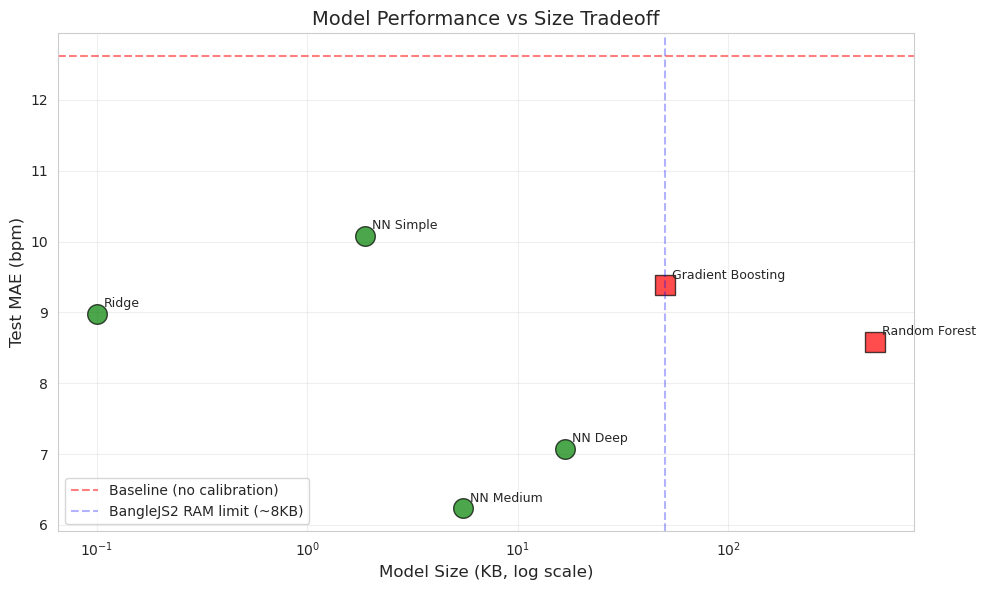


Legend:
  🟢 Green circle = Embeddable on BangleJS2
  🟠 Orange square = Might work with optimization
  🔴 Red square = Too large for embedded deployment

NEURAL NETWORK ARCHITECTURE (NN Medium)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,037 (15.77 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 2,628 (10.27 KB)

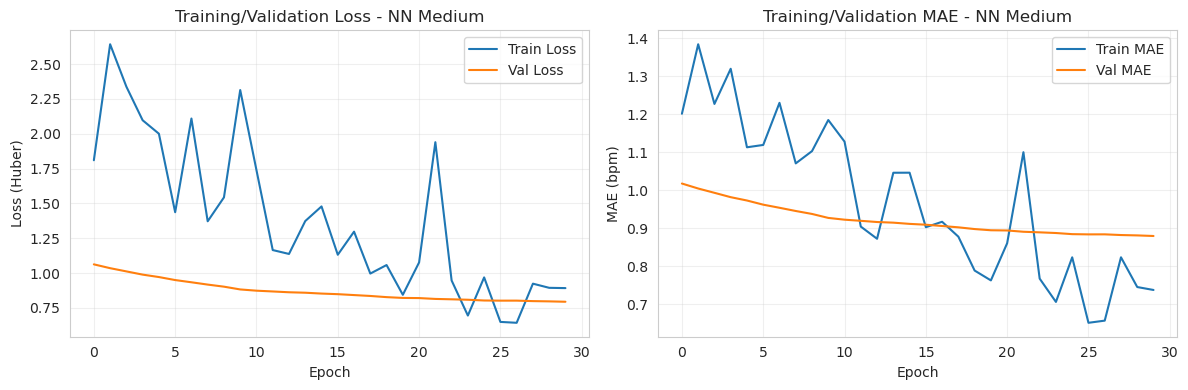


✓ MODEL EXPORT COMPLETE
✓ Saved model package to: models/hrm_calibration_model.pkl
✓ Saved lookup table to: models/hrm_calibration_lookup.json
✓ No data leakage - features engineered separately per split


In [94]:
# %% [markdown]
# ## Step 7: Train & Evaluate Models

MAX_MODEL_SIZE = 50

print(f"\n{'='*60}")
print("MODEL TRAINING & EVALUATION")
print(f"{'='*60}")

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"\n[1/7] Ridge Regression")
print(f"      Test MAE: {mae_ridge:.2f} bpm | RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.3f}")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=10, 
                           random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n[2/7] Random Forest")
print(f"      Test MAE: {mae_rf:.2f} bpm | RMSE: {rmse_rf:.2f} | R²: {r2_rf:.3f}")

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1,
                               random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\n[3/7] Gradient Boosting")
print(f"      Test MAE: {mae_gb:.2f} bpm | RMSE: {rmse_gb:.2f} | R²: {r2_gb:.3f}")

# XGBoost (if available)
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                 random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    print(f"\n[4/7] XGBoost")
    print(f"      Test MAE: {mae_xgb:.2f} bpm | RMSE: {rmse_xgb:.2f} | R²: {r2_xgb:.3f}")
    
    has_xgb = True
except ImportError:
    print(f"\n[4/7] XGBoost - SKIPPED (not installed)")
    has_xgb = False

# Simple Neural Network (shallow, embeddable)
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    import tensorflow as tf
    
    # Set random seeds for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # Check target distribution
    print(f"\n[NN Debug] Target (HRREF) stats:")
    print(f"  Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
    print(f"  Min: {y_train.min():.2f}, Max: {y_train.max():.2f}")
    
    # Normalize targets for neural networks
    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std
    
    print(f"  Normalized - Mean: {y_train_norm.mean():.2f}, Std: {y_train_norm.std():.2f}")
    
    # Small network that could fit on BangleJS2 (8KB RAM)
    nn_simple = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    nn_simple.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Train with validation split and early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=30, 
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=0
    )
    
    history_simple = nn_simple.fit(
        X_train_scaled, y_train_norm, 
        validation_split=0.2,
        epochs=300, 
        batch_size=32, 
        verbose=0, 
        callbacks=[early_stop, reduce_lr]
    )
    
    # Predict and denormalize
    y_pred_nn_simple_norm = nn_simple.predict(X_test_scaled, verbose=0).flatten()
    y_pred_nn_simple = (y_pred_nn_simple_norm * y_std) + y_mean
    
    mae_nn_simple = mean_absolute_error(y_test, y_pred_nn_simple)
    rmse_nn_simple = np.sqrt(mean_squared_error(y_test, y_pred_nn_simple))
    r2_nn_simple = r2_score(y_test, y_pred_nn_simple)
    
    # Calculate model size
    nn_simple_params = nn_simple.count_params()
    nn_simple_size_kb = (nn_simple_params * 4) / 1024  # 4 bytes per float32
    
    print(f"\n[5/7] Simple Neural Network (Embeddable)")
    print(f"      Architecture: 16→8→1 neurons + BatchNorm")
    print(f"      Parameters: {nn_simple_params:,} (~{nn_simple_size_kb:.1f} KB)")
    print(f"      Trained: {len(history_simple.history['loss'])} epochs")
    print(f"      Final train loss: {history_simple.history['loss'][-1]:.4f}")
    print(f"      Final val loss: {history_simple.history['val_loss'][-1]:.4f}")
    print(f"      Test MAE: {mae_nn_simple:.2f} bpm | RMSE: {rmse_nn_simple:.2f} | R²: {r2_nn_simple:.3f}")
    
    has_nn_simple = True
except ImportError:
    print(f"\n[5/7] Simple Neural Network - SKIPPED (TensorFlow not installed)")
    has_nn_simple = False
except Exception as e:
    print(f"\n[5/7] Simple Neural Network - ERROR: {e}")
    import traceback
    traceback.print_exc()
    has_nn_simple = False

# Medium Neural Network
try:
    nn_medium = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    nn_medium.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    history_medium = nn_medium.fit(
        X_train_scaled, y_train_norm,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )
    
    y_pred_medium_norm = nn_medium.predict(X_test_scaled, verbose=0).flatten()
    y_pred_medium = (y_pred_medium_norm * y_std) + y_mean
    
    mae_medium = mean_absolute_error(y_test, y_pred_medium)
    rmse_medium = np.sqrt(mean_squared_error(y_test, y_pred_medium))
    r2_medium = r2_score(y_test, y_pred_medium)
    
    medium_params = nn_medium.count_params()
    medium_size_kb = (medium_params * 4) / 1024
    
    print(f"\n[6/7] Medium Neural Network")
    print(f"      Architecture: 32→16→8→1 neurons + BatchNorm + Dropout")
    print(f"      Parameters: {medium_params:,} (~{medium_size_kb:.1f} KB)")
    print(f"      Trained: {len(history_medium.history['loss'])} epochs")
    print(f"      Final train loss: {history_medium.history['loss'][-1]:.4f}")
    print(f"      Final val loss: {history_medium.history['val_loss'][-1]:.4f}")
    print(f"      Test MAE: {mae_medium:.2f} bpm | RMSE: {rmse_medium:.2f} | R²: {r2_medium:.3f}")
    
    has_medium = True
except (ImportError, NameError):
    print(f"\n[6/7] Medium Neural Network - SKIPPED (TensorFlow not available)")
    has_medium = False
except Exception as e:
    print(f"\n[6/7] Medium Neural Network - ERROR: {e}")
    import traceback
    traceback.print_exc()
    has_medium = False

# Deep Neural Network (high capacity)
try:
    nn_deep = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    nn_deep.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    history_deep = nn_deep.fit(
        X_train_scaled, y_train_norm,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )
    
    y_pred_deep_norm = nn_deep.predict(X_test_scaled, verbose=0).flatten()
    y_pred_deep = (y_pred_deep_norm * y_std) + y_mean
    
    mae_deep = mean_absolute_error(y_test, y_pred_deep)
    rmse_deep = np.sqrt(mean_squared_error(y_test, y_pred_deep))
    r2_deep = r2_score(y_test, y_pred_deep)
    
    deep_params = nn_deep.count_params()
    deep_size_kb = (deep_params * 4) / 1024
    
    print(f"\n[7/7] Deep Neural Network (High Capacity)")
    print(f"      Architecture: 64→32→16→8→1 neurons + BatchNorm + Dropout")
    print(f"      Parameters: {deep_params:,} (~{deep_size_kb:.1f} KB)")
    print(f"      Trained: {len(history_deep.history['loss'])} epochs")
    print(f"      Final train loss: {history_deep.history['loss'][-1]:.4f}")
    print(f"      Final val loss: {history_deep.history['val_loss'][-1]:.4f}")
    print(f"      Test MAE: {mae_deep:.2f} bpm | RMSE: {rmse_deep:.2f} | R²: {r2_deep:.3f}")
    
    has_deep = True
except (ImportError, NameError):
    print(f"\n[7/7] Deep Neural Network - SKIPPED (TensorFlow not available)")
    has_deep = False
except Exception as e:
    print(f"\n[7/7] Deep Neural Network - ERROR: {e}")
    import traceback
    traceback.print_exc()
    has_deep = False


# %% [markdown]
# ## Step 8: Compare Models & Performance/Cost Tradeoff

results_data = {
    'Model': ['Baseline', 'Ridge', 'Random Forest', 'Gradient Boosting'],
    'Test MAE': [raw_mae, mae_ridge, mae_rf, mae_gb],
    'Test RMSE': [np.nan, rmse_ridge, rmse_rf, rmse_gb],
    'Test R²': [np.nan, r2_ridge, r2_rf, r2_gb],
    'Model Size (KB)': [0, 0.1, 500, 50],  # Rough estimates
    'Embeddable': ['N/A', '✓', '✗', '✗']
}

if has_xgb:
    results_data['Model'].append('XGBoost')
    results_data['Test MAE'].append(mae_xgb)
    results_data['Test RMSE'].append(rmse_xgb)
    results_data['Test R²'].append(r2_xgb)
    results_data['Model Size (KB)'].append(100)
    results_data['Embeddable'].append('✗')

if has_nn_simple:
    results_data['Model'].append('NN Simple')
    results_data['Test MAE'].append(mae_nn_simple)
    results_data['Test RMSE'].append(rmse_nn_simple)
    results_data['Test R²'].append(r2_nn_simple)
    results_data['Model Size (KB)'].append(nn_simple_size_kb)
    results_data['Embeddable'].append('✓' if nn_simple_size_kb < MAX_MODEL_SIZE else '?')

if has_medium:
    results_data['Model'].append('NN Medium')
    results_data['Test MAE'].append(mae_medium)
    results_data['Test RMSE'].append(rmse_medium)
    results_data['Test R²'].append(r2_medium)
    results_data['Model Size (KB)'].append(medium_size_kb)
    results_data['Embeddable'].append('✓' if medium_size_kb < MAX_MODEL_SIZE else '?')

if has_deep:
    results_data['Model'].append('NN Deep')
    results_data['Test MAE'].append(mae_deep)
    results_data['Test RMSE'].append(rmse_deep)
    results_data['Test R²'].append(r2_deep)
    results_data['Model Size (KB)'].append(deep_size_kb)
    results_data['Embeddable'].append('✓' if deep_size_kb < MAX_MODEL_SIZE else '?')

results_df = pd.DataFrame(results_data)

# Select best model by test MAE
test_scores = dict(zip(results_df['Model'][1:], results_df['Test MAE'][1:]))
best_model_name = min(test_scores, key=test_scores.get)

print(f"\n{'='*60}")
print(f"BEST MODEL BY ACCURACY: {best_model_name}")
print(f"  Test MAE: {test_scores[best_model_name]:.2f} bpm")
print(f"  Improvement: {raw_mae - test_scores[best_model_name]:.2f} bpm ({((raw_mae - test_scores[best_model_name])/raw_mae*100):.1f}%)")
print(f"{'='*60}")

print(f"\n{results_df.to_string(index=False)}")

# BangleJS2 constraints: ~8KB RAM, ~512KB Flash
print(f"\n{'='*60}")
print("BANGLEJS2 DEPLOYMENT ANALYSIS")
print(f"{'='*60}")
print("Constraints:")
print("  - RAM: ~8 KB available")
print("  - Flash: ~512 KB available")
print("  - No FPU (floating point unit)")
print("\nEmbeddable candidates (✓):")
embeddable = results_df[results_df['Embeddable'] == '✓']
if len(embeddable) > 0:
    for _, row in embeddable.iterrows():
        print(f"  • {row['Model']}: {row['Test MAE']:.2f} bpm MAE, ~{row['Model Size (KB)']:.1f} KB")
else:
    print("  None found - consider model quantization or pruning")

# Performance vs Size scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

for _, row in results_df[1:].iterrows():
    color = 'green' if row['Embeddable'] == '✓' else 'orange' if row['Embeddable'] == '?' else 'red'
    marker = 'o' if row['Embeddable'] == '✓' else 's'
    ax.scatter(row['Model Size (KB)'], row['Test MAE'], 
              s=200, c=color, marker=marker, alpha=0.7, edgecolors='black')
    ax.annotate(row['Model'], (row['Model Size (KB)'], row['Test MAE']),
               xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.axhline(raw_mae, color='red', linestyle='--', alpha=0.5, label='Baseline (no calibration)')
ax.axvline(MAX_MODEL_SIZE, color='blue', linestyle='--', alpha=0.3, label='BangleJS2 RAM limit (~8KB)')
ax.set_xlabel('Model Size (KB, log scale)', fontsize=12)
ax.set_ylabel('Test MAE (bpm)', fontsize=12)
ax.set_xscale('log')
ax.set_title('Model Performance vs Size Tradeoff', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nLegend:")
print("  🟢 Green circle = Embeddable on BangleJS2")
print("  🟠 Orange square = Might work with optimization")
print("  🔴 Red square = Too large for embedded deployment")


# %% [markdown]
# ## Step 9: Feature Importance Analysis (Best Model)

model_map = {
    'Ridge': ridge,
    'Random Forest': rf,
    'Gradient Boosting': gb
}
if has_xgb:
    model_map['XGBoost'] = xgb_model
if has_nn_simple:
    model_map['NN Simple'] = nn_simple
if has_medium:
    model_map['NN Medium'] = nn_medium
if has_deep:
    model_map['NN Deep'] = nn_deep

best_model = model_map[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"TOP 10 FEATURE IMPORTANCES ({best_model_name})")
    print(f"{'='*60}")
    print(importances.head(10).to_string(index=False))
    
    # Only plot if we have importances
    if len(importances) > 0:
        plt.figure(figsize=(10, 6))
        top_15 = importances.head(15)
        plt.barh(range(len(top_15)), top_15['importance'].values, color='darkgreen')
        plt.yticks(range(len(top_15)), top_15['feature'].values)
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
elif best_model_name == 'Ridge':
    # For Ridge, show coefficients instead
    coefficients = pd.DataFrame({
        'feature': selected_features,
        'coefficient': np.abs(best_model.coef_)
    }).sort_values('coefficient', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"TOP 10 COEFFICIENTS ({best_model_name})")
    print(f"{'='*60}")
    print(coefficients.head(10).to_string(index=False))
    
    if len(coefficients) > 0:
        plt.figure(figsize=(10, 6))
        top_15 = coefficients.head(15)
        plt.barh(range(len(top_15)), top_15['coefficient'].values, color='darkblue')
        plt.yticks(range(len(top_15)), top_15['feature'].values)
        plt.xlabel('Absolute Coefficient Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'Top 15 Feature Coefficients - {best_model_name}', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
elif 'NN' in best_model_name or 'LSTM' in best_model_name:
    print(f"\n{'='*60}")
    print(f"NEURAL NETWORK ARCHITECTURE ({best_model_name})")
    print(f"{'='*60}")
    best_model.summary()
    
    # Plot training history if available
    if best_model_name == 'NN Simple' and has_nn_simple:
        history = history_simple
    elif best_model_name == 'NN Medium' and has_medium:
        history = history_medium
    elif best_model_name == 'NN Deep' and has_deep:
        history = history_deep
    else:
        history = None
    
    if history:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Huber)')
        plt.title(f'Training/Validation Loss - {best_model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE (bpm)')
        plt.title(f'Training/Validation MAE - {best_model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# %% [markdown]
# ## Step 10: Export Model Package

os.makedirs('models', exist_ok=True)

model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': selected_features,
    'model_name': best_model_name,
    'test_mae': test_scores[best_model_name],
    'baseline_mae': raw_mae
}

joblib.dump(model_package, 'models/hrm_calibration_model.pkl')

# Create lookup table from TRAINING data only
lookup_bins = np.arange(40, 200, 5)
lookup_table = []
for i in range(len(lookup_bins) - 1):
    bin_min = lookup_bins[i]
    bin_max = lookup_bins[i + 1]
    mask = (train_data['HEART_RATE'] >= bin_min) & (train_data['HEART_RATE'] < bin_max)
    if mask.sum() > 0:
        avg_corr = (train_data.loc[mask, 'HRREF'] - train_data.loc[mask, 'HEART_RATE']).mean()
        lookup_table.append({
            'hr_min': int(bin_min),
            'hr_max': int(bin_max),
            'correction': round(float(avg_corr), 2),
            'n_samples': int(mask.sum())
        })

with open('models/hrm_calibration_lookup.json', 'w') as f:
    json.dump(lookup_table, f, indent=2)

print(f"\n{'='*60}")
print("✓ MODEL EXPORT COMPLETE")
print(f"{'='*60}")
print(f"✓ Saved model package to: models/hrm_calibration_model.pkl")
print(f"✓ Saved lookup table to: models/hrm_calibration_lookup.json")
print(f"✓ No data leakage - features engineered separately per split")

ValueError: x and y must have same first dimension, but have shapes (200,) and (72,)

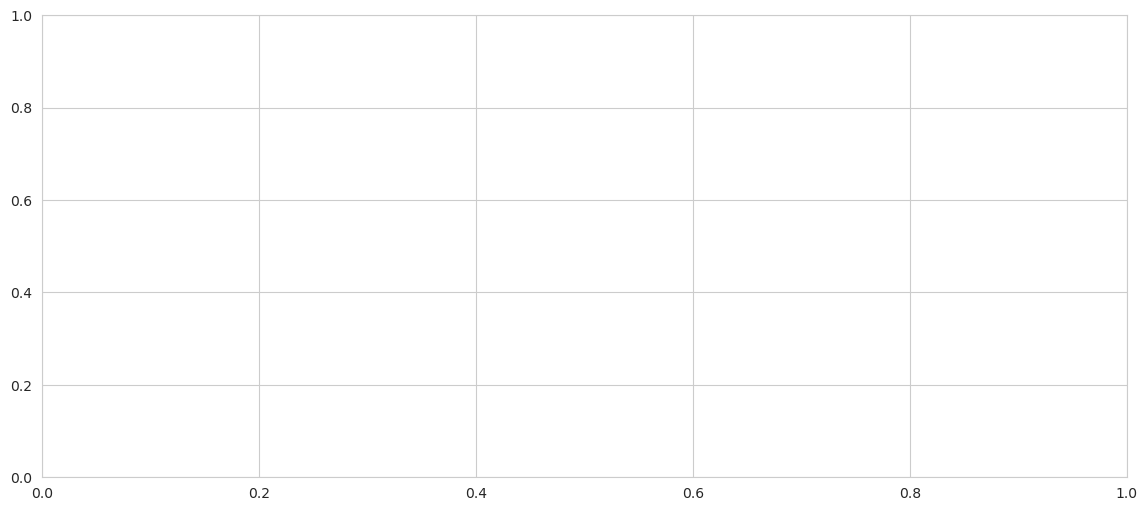

In [96]:
# %% Visualize time-series prediction
# Show a sample window of predictions
sample_start = len(y_test) // 2
sample_end = sample_start + 200

fig, ax = plt.subplots(figsize=(14, 6))

x_axis = range(sample_start, sample_end)
ax.plot(x_axis, y_test.iloc[sample_start:sample_end], 'b-', label='Actual HR', linewidth=2)
ax.plot(x_axis, y_pred_gb[sample_start:sample_end], 'r--', label='Predicted HR (GB)', linewidth=2, alpha=0.7)

ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax.set_title('Heart Rate Prediction Over Time (Sample Window)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% Feature importance
best_model_idx = np.argmin([mae_ridge, mae_rf, mae_gb])
best_model_name = ['Ridge', 'Random Forest', 'Gradient Boosting'][best_model_idx]
best_model = [ridge, rf, gb][best_model_idx]

print(f"\nBest model: {best_model_name}")

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 20 Features ({best_model_name})', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))

# %% [markdown]
# ## Step 4: Apply to Bangle.js Data

# %% Prepare Bangle.js data - use the same cleaned data
bangle_df = hr_data[hr_data['device_type'].str.contains('BANGLE', case=False, na=False)].copy()
bangle_df = bangle_df.sort_values('datetime').reset_index(drop=True)

print(f"Bangle.js data before features: {len(bangle_df):,} measurements")
print(f"Time range: {bangle_df['datetime'].min()} to {bangle_df['datetime'].max()}")

# Create same features
print("\nCreating temporal features for Bangle.js data...")
bangle_df = create_temporal_features(bangle_df)
print(f"Bangle.js data after features: {len(bangle_df):,} measurements")

# %% Apply dynamics model to Bangle.js
X_bangle = bangle_df[feature_cols].copy()

if best_model_name == 'Ridge':
    X_bangle_scaled = scaler.transform(X_bangle)
    bangle_predictions = best_model.predict(X_bangle_scaled)
else:
    bangle_predictions = best_model.predict(X_bangle)

bangle_df['hr_predicted'] = bangle_predictions
bangle_df['hr_correction'] = bangle_predictions - bangle_df['HEART_RATE']

print(f"\nBangle.js predictions generated!")
print(f"Mean correction: {bangle_df['hr_correction'].mean():.2f} bpm")
print(f"Std correction: {bangle_df['hr_correction'].std():.2f} bpm")

# %% Visualize Bangle.js corrections
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original vs corrected
sample_size = min(500, len(bangle_df))
sample = bangle_df.iloc[:sample_size]

axes[0, 0].plot(sample['datetime'], sample['HEART_RATE'], label='Raw Bangle.js', alpha=0.7)
axes[0, 0].plot(sample['datetime'], sample['hr_predicted'], label='Corrected (Model)', alpha=0.7)
axes[0, 0].set_xlabel('Time', fontsize=12)
axes[0, 0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[0, 0].set_title('Raw vs Model-Corrected Heart Rate', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Correction distribution
axes[0, 1].hist(bangle_df['hr_correction'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].axvline(bangle_df['hr_correction'].mean(), color='g', linestyle='--', lw=2,
                   label=f'Mean: {bangle_df["hr_correction"].mean():.1f} bpm')
axes[0, 1].set_xlabel('Correction (bpm)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Corrections', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Correction vs raw HR
axes[1, 0].scatter(bangle_df['HEART_RATE'], bangle_df['hr_correction'], alpha=0.3, s=5)
axes[1, 0].axhline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Raw Bangle.js HR (bpm)', fontsize=12)
axes[1, 0].set_ylabel('Correction (bpm)', fontsize=12)
axes[1, 0].set_title('Correction vs Raw Heart Rate', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# HR distributions
axes[1, 1].hist(bangle_df['HEART_RATE'], bins=50, alpha=0.5, label='Raw Bangle.js', edgecolor='black')
axes[1, 1].hist(bangle_df['hr_predicted'], bins=50, alpha=0.5, label='Corrected', edgecolor='black')
axes[1, 1].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('HR Distribution: Raw vs Corrected', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [87]:
# %% [markdown]
# ## Step 5: Export Model

# %%
import os
os.makedirs('models', exist_ok=True)

# Save model
model_package = {
    'model': best_model,
    'scaler': scaler if best_model_name == 'Ridge' else None,
    'feature_names': feature_cols,
    'model_name': best_model_name,
    'mae': [mae_ridge, mae_rf, mae_gb][best_model_idx],
    'rmse': [rmse_ridge, rmse_rf, rmse_gb][best_model_idx],
    'r2': [r2_ridge, r2_rf, r2_gb][best_model_idx]
}

joblib.dump(model_package, 'models/hr_dynamics_model.pkl')
print(f"✓ Saved model: models/hr_dynamics_model.pkl")

# Save metadata
metadata = {
    'model_type': 'hr_dynamics',
    'model_name': best_model_name,
    'features': feature_cols,
    'mae_bpm': float(model_package['mae']),
    'rmse_bpm': float(model_package['rmse']),
    'r2_score': float(model_package['r2']),
    'training_samples': int(len(X_train)),
    'description': 'Predicts current HR from recent HR history and dynamics'
}

with open('models/hr_dynamics_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved metadata: models/hr_dynamics_metadata.json")

# %% Export corrected Bangle.js data
bangle_export = bangle_df[['datetime', 'HEART_RATE', 'hr_predicted', 'hr_correction']].copy()
bangle_export.columns = ['datetime', 'hr_raw', 'hr_corrected', 'correction_applied']
bangle_export.to_csv('bangle_corrected_hr.csv', index=False)
print(f"✓ Saved corrected data: bangle_corrected_hr.csv")

# %% Usage instructions

✓ Saved model: models/hr_dynamics_model.pkl
✓ Saved metadata: models/hr_dynamics_metadata.json
✓ Saved corrected data: bangle_corrected_hr.csv


## DEPLOYMENT GUIDE

This model learns YOUR personal heart rate dynamics from reference data.
It predicts what your HR should be based on recent HR history.

HOW IT WORKS:
1. Collects last N heart rate readings from Bangle.js
2. Computes rolling statistics and rate of change
3. Predicts current HR using learned dynamics
4. Can smooth noisy Bangle.js readings

DEPLOYMENT OPTIONS:

A) REAL-TIME ON BANGLE.JS:
   - Keep buffer of a number of HR readings
   - Compute features (rolling means, changes, etc.)
   - Apply model to predict/smooth current HR
   - Lightweight models are always picked here to work on embedded systems

B) POST-PROCESSING:
   - Collect raw Bangle.js data
   - Apply model offline to clean/correct readings
   - Use for historical data analysis

C) HYBRID APPROACH:
   - Use dynamics model for smoothing
   - Periodically sync with reference device to recalibrate

This model knows how YOUR HR naturally changes. If Bangle.js gives a noisy/wrong reading, the model can detect
it doesn't follow your typical patterns and correct it.
